## Specification of start years for PPEs
Seeking start years that are ~25 years apart and sample multi-decadal variability of Southern Ocean ventilation
- calculate AABW overturning strength
- get pdf of AABW overturning strength
- sample evenly from this pdf

Also look at quantities such as ENSO to ensure even sampling.

**9.20.21** Realised that sampling strategy based on selecting one year from each of 10 bins actually gives a **uniform** distribution across sampled AABW strengths. This is of course not the same statistics as the control. So, I think I actually want to take from each bin a number of start years consistent with a discrete normal distribution. This would be, I think, (0,0,0,2,3,3,2,0,0,0).

In [32]:
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram
import pandas as pd
import glob
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [77]:
paths = '../data/raw/CTRL/pp/ocean_annual_rho2/ts/annual/5yr/ocean_annual_rho2.0[2-4]*.vmo.nc'
ds = xr.open_mfdataset(glob.glob(paths),use_cftime=True)

In [78]:
def cumsum_r(da,dim):
    '''Reverse cumulative sum'''
    cumsum = da.reindex({dim:list(reversed(da[dim]))}).cumsum(dim)
    return cumsum.reindex({dim:list(reversed(cumsum[dim]))})

def calc_psi(vmo,latitude,zdim='rho2_l'):
    '''Calculate overturning streamfunction'''
    return cumsum_r(vmo.sum('xh').sel(yq=latitude,method='nearest'),dim='rho2_l')

def calc_maxpsi(vmo,latitude,zdim='rho2_l',threshold=1036.7):
    '''Retrieve maximum of psi in z-dimension'''
    psi = calc_psi(vmo,latitude,zdim=zdim)
    return psi.where(psi[zdim]>threshold).max(zdim)

In [79]:
vmo = ds['vmo']
maxpsi = calc_maxpsi(vmo,-60)
with ProgressBar():
    maxpsi = maxpsi.load()

[########################################] | 100% Completed | 36.1s


In [86]:
df = pd.DataFrame({'maxpsi':maxpsi,'time':np.arange(len(maxpsi['time']))})
df

,maxpsi,time
0,6.666611e+09,0
1,1.302081e+10,1
2,1.482284e+10,2
3,1.358757e+10,3
4,1.666255e+10,4
...,...,...
295,1.029211e+10,295
296,1.061461e+10,296
297,9.624909e+09,297
298,1.054232e+10,298


In [81]:
# Calculate percentiles
bins = df.quantile(q=np.arange(0,1.1,0.1))['maxpsi'].to_numpy()
bins

array([4.04562842e+09, 1.06039225e+10, 1.29125949e+10, 1.41909518e+10,
       1.51467321e+10, 1.62263613e+10, 1.72729426e+10, 1.82999728e+10,
       1.96766904e+10, 2.15408617e+10, 2.79281009e+10])

In [112]:
def grab(x):
    return np.random.choice(x,1)[0]

def find_years(groups):
    times = groups['time'].apply(grab)
    years = np.sort(times.to_numpy())
    return years

def eval_spacing(years,minspacing=10):
    return np.all(np.greater(np.diff(years),minspacing))

def get_years_with_spacing(groups,minspacing=10):
    allgreater=False
    ni=0
    while not allgreater:
        years = find_years(groups)
        allgreater = eval_spacing(years,minspacing=minspacing)
        ni+=1
        if ni>10000:
            print("WARNING: suitable start dates not found after {} iterations".format(ni))
            allgreater=True
    return years,ni

In [143]:
dfshort=df[:-10] # Ensemble runs could be up to 10 years, so constrain to be within first 290 years
bins_pd = pd.cut(dfshort['maxpsi'],bins)
groups = dfshort.groupby(bins_pd)
%time years, ni = get_years_with_spacing(groups,minspacing=25)
print("years : "+str(years))
print("spacing : "+str(np.diff(years)))
print("niter : "+str(ni))

CPU times: user 17.2 s, sys: 14.3 ms, total: 17.2 s
Wall time: 17.2 s
years : [ 36  52  70  77 113 121 151 244 259 280]
spacing : [16 18  7 36  8 30 93 15 21]
niter : 10001


### 25-year spacings
years : [  8  34  61  93 126 169 211 237 261 287]  
spacing : [26 27 32 33 43 42 26 24 26]

In [139]:
years = np.array([8,  34,  61,  93, 126, 169, 211, 237, 261, 287])

### Histogram

In [140]:
maxpsi_sample = maxpsi.isel(time=years)
nbins = 30
binmin=0.4e10
binmax=2.9e10
bins_now = np.linspace(binmin,binmax,nbins)
maxpsi_hist = histogram(maxpsi,bins=[bins_now],dim=['time'],density=True)
# Get pdf in quartile bins
maxpsi_sample_hist = histogram(maxpsi_sample,bins=[bins],dim=['time'],density=True)

Text(0.5, 1.0, 'AABW pdf')

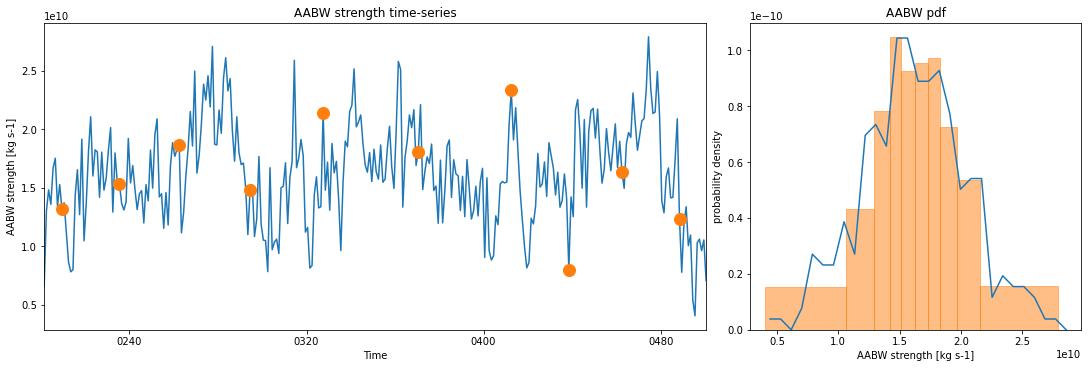

In [141]:
fig = plt.figure(constrained_layout=True,figsize=(15,5))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0:2])
ax2 = fig.add_subplot(spec[2])

ax1.plot(maxpsi['time'],maxpsi)
ax1.plot(maxpsi_sample['time'],maxpsi_sample,'o',markersize=12)
ax1.set_ylabel('AABW strength [kg s-1]')
ax1.set_xlabel('Time')
ax1.set_title('AABW strength time-series')
ax1.autoscale(enable=True, axis='x', tight=True)

ax2.plot(maxpsi_hist['vmo_bin'],maxpsi_hist)
ax2.bar(maxpsi_sample_hist['vmo_bin'],maxpsi_sample_hist,width=np.diff(bins),color='tab:orange',alpha=0.5,edgecolor='tab:orange')
ax2.set_ylabel('probability density')
ax2.set_xlabel('AABW strength [kg s-1]')
ax2.set_title('AABW pdf');

<BarContainer object of 19 artists>

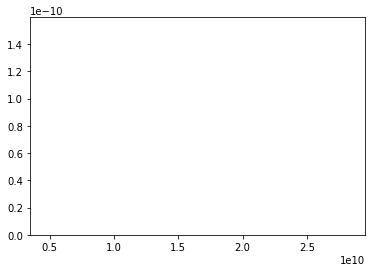

In [66]:

plt.bar(maxpsi_sample_hist['vmo_bin'],maxpsi_sample_hist)

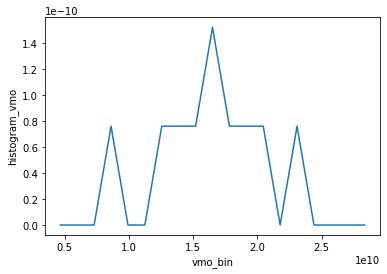

In [61]:
maxpsi_sample_hist.plot()